# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



#### In this assignment, we will work on the bank loan data. The task is to build a model given the information of clients to predict whether the clients default or not. The data file is `loan_Data.csv`.  The target variable is `loanDefault`, which can be Fully Paid or Charged Off. The data includes some information about the payment behavior and customer characteristics such as job and purpose acquiring the current loan. You could view the description of the variables in `loan_param.xlsx`.



---

### Global Toolbox

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score


pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.style.use('ggplot')


_____

## Question 1: /10 pts

#### 1.1 Load the data `loan_Data.csv` and display the last 10 rows. How many features and how many obersvations are there in the dataset?

In [2]:
# Load the data and display

# 2 pt

df = pd.read_csv('loan_Data.csv', delimiter=';')

df.tail(10)

,loanAmnt,annualInc,application_type,int_rate,revol_bal,revol_util,dti,emp_length,grade,homeOwnership,installment,job,loanDefault,mortAcc,pub_rec_bankruptcies,purpose,term,Year
990,3900.0,38100.0,INDIVIDUAL,7.90,10936.0,91.9,15.06,6,A,MORTGAGE,122.04,University of North Carolina,Fully Paid,6,0,credit_card,36,2011
991,12000.0,70000.0,INDIVIDUAL,6.62,22219.0,60.1,28.58,10,A,MORTGAGE,368.45,school dist. 21,Fully Paid,12,0,debt_consolidation,36,2012
992,3125.0,70000.0,INDIVIDUAL,11.44,2875.0,58.0,2.64,10,B,MORTGAGE,102.97,Carrier,Fully Paid,5,1,credit_card,36,2015
993,30375.0,150000.0,INDIVIDUAL,14.31,55242.0,70.8,24.79,1,C,RENT,1042.73,Vice President,Fully Paid,11,0,debt_consolidation,36,2015
994,35000.0,135000.0,INDIVIDUAL,11.99,30620.0,56.0,18.80,1,C,MORTGAGE,778.38,Registered Nurse,Fully Paid,19,0,debt_consolidation,60,2015
995,10000.0,40000.0,INDIVIDUAL,17.86,9023.0,52.5,26.07,5,D,MORTGAGE,253.18,property manager,Charged Off,11,0,credit_card,60,2015
996,9000.0,96000.0,INDIVIDUAL,6.49,17017.0,30.4,8.91,1,A,RENT,275.81,Communications Manager,Fully Paid,16,0,credit_card,36,2014
997,5600.0,65000.0,INDIVIDUAL,8.90,21409.0,92.7,12.09,4,A,MORTGAGE,177.82,Grasmere Place,Fully Paid,11,0,vacation,36,2012
998,25000.0,79980.0,INDIVIDUAL,19.72,9706.0,69.8,17.73,2,D,RENT,658.46,bed bath & beyond,Fully Paid,9,0,debt_consolidation,60,2012
999,15000.0,63000.0,INDIVIDUAL,11.99,15493.0,69.5,17.57,2,B,RENT,498.15,Account Manager,Fully Paid,28,0,credit_card,36,2014


**Written Answer** [2 pt]: 

There are 1000 observations in the dataset.

#### 1.2 Create a bar graph to visualize the count of `Charged Off` and `Fully Paid`. Calculate the percentage of `Charged off`, which is the percentage of default.

<Axes: xlabel='loanDefault'>

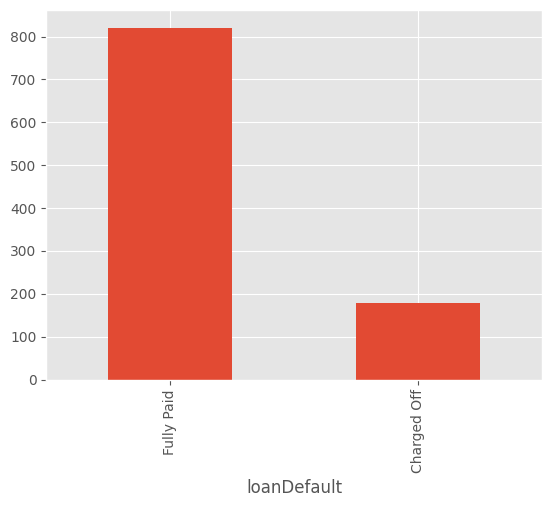

In [3]:
# Plot

df['loanDefault'].value_counts().plot(kind='bar')

# 2pts

In [4]:
# Calculate the percentage

p = df['loanDefault'].value_counts()[1] / len(df['loanDefault'])
p

0.179

**Written Answer** [2 pt]: 

The percentage is 17.9%.

#### 1.3 Change the values of the column `loanDefault` to 1 if the loan is `Charged Off` and 0 if it is `Fully Paid`. 

In [5]:
# Change the values

df['loanDefault'] = df['loanDefault'].replace(['Fully Paid', 'Charged Off'], [0,1])

df.tail(5)

# 2 pts

,loanAmnt,annualInc,application_type,int_rate,revol_bal,revol_util,dti,emp_length,grade,homeOwnership,installment,job,loanDefault,mortAcc,pub_rec_bankruptcies,purpose,term,Year
995,10000.0,40000.0,INDIVIDUAL,17.86,9023.0,52.5,26.07,5,D,MORTGAGE,253.18,property manager,1,11,0,credit_card,60,2015
996,9000.0,96000.0,INDIVIDUAL,6.49,17017.0,30.4,8.91,1,A,RENT,275.81,Communications Manager,0,16,0,credit_card,36,2014
997,5600.0,65000.0,INDIVIDUAL,8.90,21409.0,92.7,12.09,4,A,MORTGAGE,177.82,Grasmere Place,0,11,0,vacation,36,2012
998,25000.0,79980.0,INDIVIDUAL,19.72,9706.0,69.8,17.73,2,D,RENT,658.46,bed bath & beyond,0,9,0,debt_consolidation,60,2012
999,15000.0,63000.0,INDIVIDUAL,11.99,15493.0,69.5,17.57,2,B,RENT,498.15,Account Manager,0,28,0,credit_card,36,2014


_____________

## Question 2: /16 pts 
Here we are interested in if the distribution of income is different between clients who defaulted and those who did not default on their loans.

#### 2.1 First create the histogram of the annual income `annualInc` for all the clients. Do not forget to label the axes.

<Axes: xlabel='Income ($)', ylabel='Frequency'>

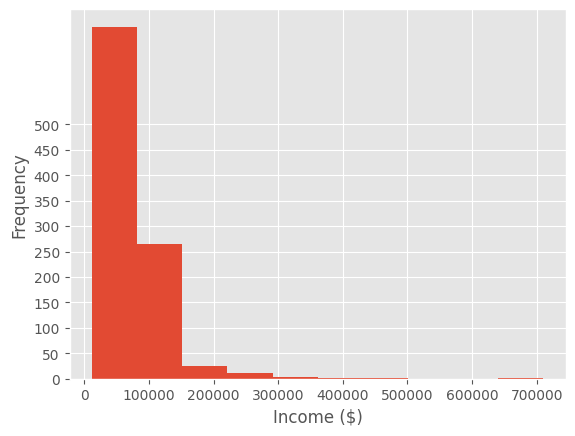

In [6]:
# Plot the distribution

df['annualInc'].plot(kind='hist', xlabel='Income ($)', yticks=range(0, 501, 50))

# 2 pts

What do you notice about the distribution of the annual income variable? What transformation would you suggest for it?

**Witten Answer**[2 pts]: 

The distribution is heavily positively skewed - much more observations fall in the lower income range than fall in the higher income range. To fix this, I'd use a log transformation, like we used on the last assignment.

#### 2.2  Apply the transformation (*i.e.*, based on your answer to the previous question) to annual income and plot the histogram of the transformed version. Update (*i.e.*, overwrite) the original entry values of `annualInc` with the transformed ones.

<Axes: xlabel='Log Income (Log $)', ylabel='Frequency'>

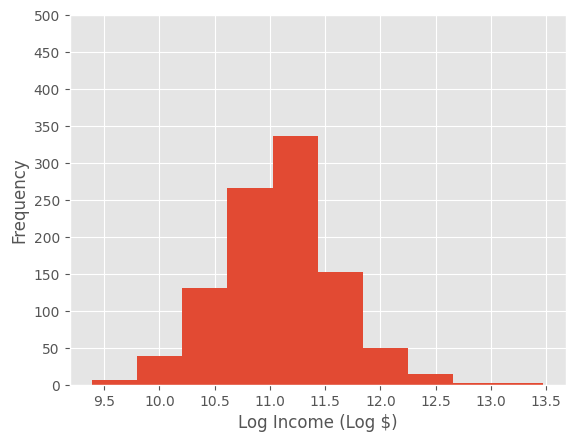

In [7]:
# Apply transformation and plot distribution

log_incomes = np.log(df['annualInc'])

log_incomes.plot(kind='hist', xlabel='Log Income (Log $)', yticks=range(0, 501, 50))


# 4 pts

In [8]:
# Overwrite

df['annualInc'] = log_incomes

# 2 pts

#### 2.3 Plot the histograms of annual income for clients who defaulted and clients who did not default. Compare to see if there is any noticeable difference. Comment qualitatively.

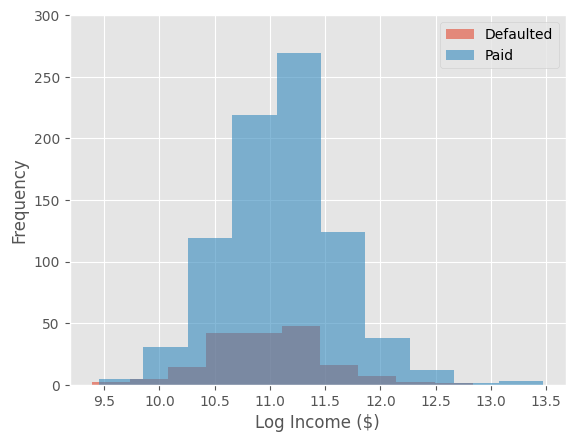

In [9]:
# Plot two distributions overlaid (use the alpha argument to create contrast in overlay plots)

fig, ax = plt.subplots()

defaults = df.loc[df['loanDefault'] == 1]
paids = df.loc[df['loanDefault'] == 0]

defaults['annualInc'].plot(kind='hist', xlabel='Log Income ($)', yticks=range(0, 301, 50), alpha=0.6, ax=ax)
paids['annualInc'].plot(kind='hist', xlabel='Log Income ($)', yticks=range(0, 301, 50), alpha=0.6, ax=ax)

ax.legend(['Defaulted', 'Paid'])

# 4 pts

**Written Answer** [2pts]:  

The shape of the distributions are more or less the same, although the distribution for those that defaulted is much flatter. Still, there is a peak between the log income of 11.0 and 11.5 for both, both distributions are still slightly positively skewed, etc.

___________

## Question 3: /14 pts

Let's build a model and use the annual income to predict the default outcome.

#### 3.1 Create a model pipline to include preprocessing step using `StandardScaler` and a basic logistic regression model (with default penalization and use `solver='lbfgs'`, `max_iter=10000` and `random_state=0`)

In [10]:
# Create a model pipline

model = Pipeline(
[('Preprocessing', StandardScaler()),
  ('Regression', LogisticRegression(solver = 'lbfgs', max_iter=10000, random_state = 0))]
)

# 2 pt

#### 3.2 Use a 80/20 train-test split of the data and remember to set `random_state=0`. Fit the model and then evaluate this model plotting the ROC curve and reporting the AUC value. 

In [11]:
# Get the X and y

X = np.array(df['annualInc']).reshape(-1, 1)
y = df['loanDefault']


# Split the train and test

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state=0)

# Fit the model

fitted = model.fit(Xtrain, ytrain)

# 4 pts

0.584


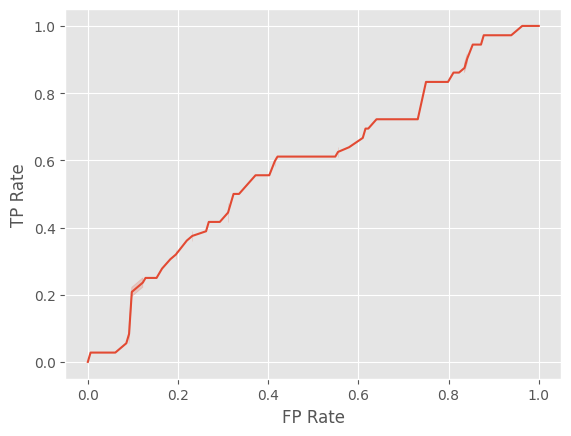

In [12]:
# Use predict_proba to get the probability of default

probs = model.predict_proba(Xtest)


# 2 pts

# Plot the ROC curve and report AUC

fpr1, tpr1, _ = roc_curve(ytest, probs[:,1], pos_label=model.classes_[1]) 

ax =sns.lineplot(x=fpr1,y=tpr1)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")

print(auc(fpr1,tpr1).round(3))

# 4 pts

Is income itself alone good enough to predict the default outcome?


**Written Answer** [2 pt] 

No, income itself is not a good enough predictor of default outcome. The AUC should be close to 1, and it is far from it. Moreover, the ROC curve should be much less linear.

____________

## Question 4: /34

Here, let's use cross-validation to find how each numeric feature performs to predict the default status.


#### 4.1: Let's write our own function instead of using `cross_val_score` to get the cross-validation AUC score. First, create a function `AUC_calculation` with inputs `(model, X, y, index_train, index_test)`  which calculates the AUC of the model trained on `index_train` and tested on `index_test`. Here we assume that X and y are pandas dataframe.

In [13]:
def AUC_calculation(model, X, y, index_train, index_test):
    # Define Xtrain, ytrain, Xtest, ytest 
    
    if (X.shape == (1000,)):
        Xtrain = np.array([X.iloc[i] for i in index_train]).reshape(-1,1)
        Xtest = np.array([X.iloc[i] for i in index_test]).reshape(-1,1)

    else:
        Xtrain = np.array([X.iloc[i] for i in index_train])
        Xtest = np.array([X.iloc[i] for i in index_test])

    ytrain = np.array([y.iloc[i] for i in index_train])
    ytest = np.array([y.iloc[i] for i in index_test])

    # Fit the model
    
    fitted = model.fit(Xtrain, ytrain)
    
    # Calculate the auc score
    
    probs = model.predict_proba(Xtest)
    
    fpr1, tpr1, _ = roc_curve(ytest, probs[:,1], pos_label=model.classes_[1]) 
    
    score_auc = auc(fpr1,tpr1).round(3)
    return score_auc
# 6 pts

#### 4.2: Create a function named `AUC_cross_validation` which has as input (model, X, y, n_fold) and does a `StratifiedKFold` cross validation with n_fold and its output should be a list with the AUC for each fold. This function will call the above function `AUC_calculation`.

In [14]:
def AUC_cross_validation(model, X, y, n_fold):
    # Create the stratified folds
    
    skf = StratifiedKFold(n_splits = n_fold)
 
    # Loop over folds and compute the AUC score for each fold
    
    split = skf.split(X,y)
    
    list_auc = []
    
    for i, (index_train, index_test) in enumerate(split):
        list_auc.append(AUC_calculation(model, X, y, index_train, index_test))
    
    return list_auc
# 6 pts 

#### 4.3 Now we are ready to estimate and compare through cross validation the performance of all the *simple models* that only use one numeric predictor as input. Here we will apply logarithm transformation for the `loanAmnt` and replace it. We will also exclude `Year` and `installment`.

In [15]:
# Extract only the numeric features
feau_num = ['int32', 'int64', 'float64']
data_num = pd.DataFrame(df.select_dtypes(include=feau_num))


# Log transform 

log_amount = np.log(df['loanAmnt'])
data_num['loanAmnt'] = log_amount

# Drop

data_num = data_num.drop(['Year', 'installment'], axis=1)


data_num.head()
# 2pts

,loanAmnt,annualInc,int_rate,revol_bal,revol_util,dti,emp_length,loanDefault,mortAcc,pub_rec_bankruptcies,term
0,9.210340,11.669929,11.44,36369.0,41.8,26.24,10,0,16,0,36
1,8.987197,11.082143,11.99,20131.0,53.3,22.05,4,0,17,0,36
2,9.655026,10.670280,10.49,11987.0,92.2,12.79,1,0,13,0,36
3,8.881836,10.896739,6.49,5472.0,21.5,2.60,6,0,6,0,36
4,10.101313,10.915088,17.27,24584.0,69.8,33.95,9,1,13,0,60


#### 4.4: Use the function `AUC_cross_validation` and the model from Q3.1 to compute cross-validation estimates of the AUC for each single numeric feature model, and use a pandas dataframe (named `AUC_models`) to store the AUC value for each fold and each of the models (use `n_fold=10`).

The column names of `AUC_models` have to be in the form `Simple-[numeric predictor variable]`, *e.g.*, `simple-int_rate`.

In [16]:
# Construct AUC_models dataframe
AUC_models = pd.DataFrame(columns = ['Simple-' + c for c in data_num.drop('loanDefault', axis=1).columns])

# Run cross-validation for each feature


for feature in AUC_models.columns:
    X = data_num[feature[7:]] # Use characters 7 onward to cut off the 'Simple-'
    y = data_num['loanDefault']
    
    aucs = AUC_cross_validation(model, X, y, 10)

    AUC_models[feature] = aucs
    
 
# 8 pts

In [17]:
# Print AUC_models dataframe. The shape should be 10 x number of features
AUC_models


,Simple-loanAmnt,Simple-annualInc,Simple-int_rate,Simple-revol_bal,Simple-revol_util,Simple-dti,Simple-emp_length,Simple-mortAcc,Simple-pub_rec_bankruptcies,Simple-term
0,0.431,0.681,0.723,0.549,0.566,0.569,0.499,0.636,0.499,0.597
1,0.624,0.434,0.797,0.566,0.522,0.541,0.649,0.454,0.482,0.646
2,0.442,0.697,0.611,0.583,0.510,0.498,0.442,0.566,0.532,0.547
3,0.563,0.631,0.651,0.575,0.422,0.645,0.520,0.489,0.567,0.597
4,0.440,0.552,0.522,0.484,0.474,0.531,0.562,0.506,0.520,0.514
5,0.523,0.450,0.746,0.593,0.507,0.527,0.533,0.509,0.488,0.507
6,0.524,0.640,0.766,0.595,0.651,0.564,0.540,0.578,0.507,0.637
7,0.630,0.483,0.762,0.438,0.556,0.523,0.431,0.465,0.519,0.742
8,0.461,0.622,0.608,0.521,0.594,0.604,0.562,0.543,0.555,0.581
9,0.486,0.526,0.441,0.532,0.387,0.589,0.599,0.466,0.470,0.529


#### 4.5: Let's use a `sns.boxplot`` (without presenting outliers) to show the distribution of the AUC scores for each feature.

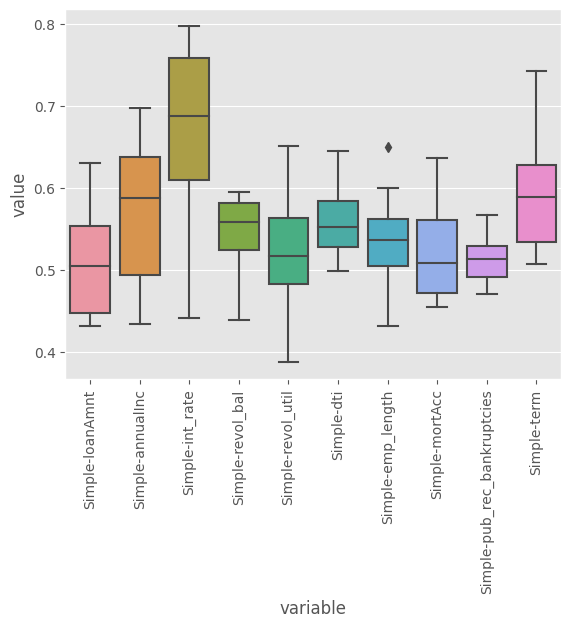

In [18]:
# Hint: use data=pd.melt(AUC_models) in boxplot

ax = sns.boxplot(data=pd.melt(AUC_models), x='variable', y='value')

ax.tick_params(axis='x', rotation=90)

#5 pts


What is the feature that yields the best performance?

**Written Answer** [1 pt]: 

The best performer is int_rate.

#### 4.6: Now let's use a model including all the numeric features for training. Again use 10-fold cross-validation to determine if this new model has better performance. Add the results to the previous AUC_models dataframe and visualize again using boxplots.

In [19]:
# Get the X and y

X = data_num.drop('loanDefault', axis = 1)
y = data_num['loanDefault']

# Calculate the auc scores using cross validation

aucs = AUC_cross_validation(model, X, y, 10)

# 4 pts 

# Include the auc scores in the AUC_models DataFrame in the column 'All_numeric'
AUC_models['All_numeric'] = aucs

# Print the new data frame 
AUC_models


,Simple-loanAmnt,Simple-annualInc,Simple-int_rate,Simple-revol_bal,Simple-revol_util,Simple-dti,Simple-emp_length,Simple-mortAcc,Simple-pub_rec_bankruptcies,Simple-term,All_numeric
0,0.431,0.681,0.723,0.549,0.566,0.569,0.499,0.636,0.499,0.597,0.767
1,0.624,0.434,0.797,0.566,0.522,0.541,0.649,0.454,0.482,0.646,0.749
2,0.442,0.697,0.611,0.583,0.510,0.498,0.442,0.566,0.532,0.547,0.648
3,0.563,0.631,0.651,0.575,0.422,0.645,0.520,0.489,0.567,0.597,0.687
4,0.440,0.552,0.522,0.484,0.474,0.531,0.562,0.506,0.520,0.514,0.540
5,0.523,0.450,0.746,0.593,0.507,0.527,0.533,0.509,0.488,0.507,0.681
6,0.524,0.640,0.766,0.595,0.651,0.564,0.540,0.578,0.507,0.637,0.753
7,0.630,0.483,0.762,0.438,0.556,0.523,0.431,0.465,0.519,0.742,0.666
8,0.461,0.622,0.608,0.521,0.594,0.604,0.562,0.543,0.555,0.581,0.692
9,0.486,0.526,0.441,0.532,0.387,0.589,0.599,0.466,0.470,0.529,0.516


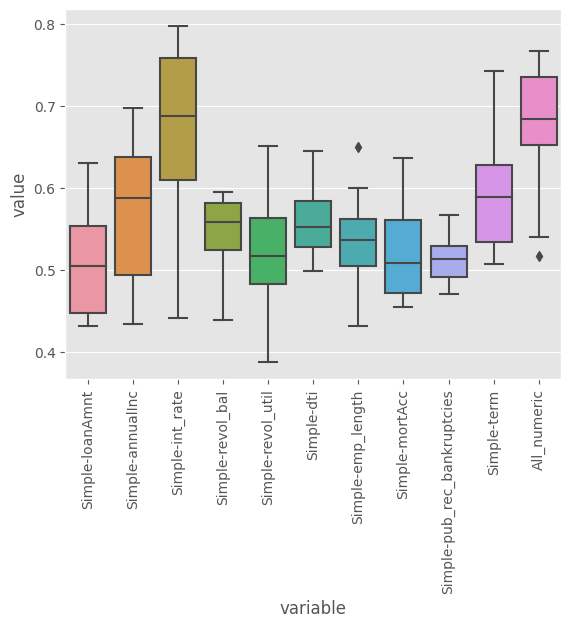

In [20]:
# Plot 

ax = sns.boxplot(data=pd.melt(AUC_models), x='variable', y='value')

ax.tick_params(axis='x', rotation=90)

# 2 pts

_____________

### Question 5: /10 pts

#### 5.1 Let's also include the categorical variable `grade` to the model (in addition to all the all the numeric features). And, again, add the results to the `AUC_models` dataframe.

In [21]:
# Convert category into numerical values

numerical_grades = df['grade'].replace(['G', 'F', 'E', 'D', 'C', 'B', 'A'], [6, 5, 4, 3, 2, 1, 0])

# Add this feature to all the numeric variables

data_num['Simple-grade'] = numerical_grades


# Calculate the auc scores using cross validation

X = data_num.drop('loanDefault', axis = 1)
y = data_num['loanDefault']

aucs = AUC_cross_validation(model, X, y, 10)

# Include the auc scores in the AUC_models DataFrame in the column 'All_numeric_&_Grade'
AUC_models['All_numeric_&_Grade'] = aucs 

AUC_models

# 4 pts

,Simple-loanAmnt,Simple-annualInc,Simple-int_rate,Simple-revol_bal,Simple-revol_util,Simple-dti,Simple-emp_length,Simple-mortAcc,Simple-pub_rec_bankruptcies,Simple-term,All_numeric,All_numeric_&_Grade
0,0.431,0.681,0.723,0.549,0.566,0.569,0.499,0.636,0.499,0.597,0.767,0.764
1,0.624,0.434,0.797,0.566,0.522,0.541,0.649,0.454,0.482,0.646,0.749,0.747
2,0.442,0.697,0.611,0.583,0.510,0.498,0.442,0.566,0.532,0.547,0.648,0.646
3,0.563,0.631,0.651,0.575,0.422,0.645,0.520,0.489,0.567,0.597,0.687,0.703
4,0.440,0.552,0.522,0.484,0.474,0.531,0.562,0.506,0.520,0.514,0.540,0.550
5,0.523,0.450,0.746,0.593,0.507,0.527,0.533,0.509,0.488,0.507,0.681,0.707
6,0.524,0.640,0.766,0.595,0.651,0.564,0.540,0.578,0.507,0.637,0.753,0.756
7,0.630,0.483,0.762,0.438,0.556,0.523,0.431,0.465,0.519,0.742,0.666,0.681
8,0.461,0.622,0.608,0.521,0.594,0.604,0.562,0.543,0.555,0.581,0.692,0.729
9,0.486,0.526,0.441,0.532,0.387,0.589,0.599,0.466,0.470,0.529,0.516,0.519


#### 5.2 Print the AUC mean and AUC standard deviation for each of the models. Which model would you choose and why?

In [22]:
stats = pd.DataFrame(columns = AUC_models.columns)

for col in stats.columns:
    mean = np.mean(AUC_models[col]) # First row is mean AUC
    sd   = np.std(AUC_models[col]) # Second row is stddev of AUC
    
    stats[col] = pd.Series([mean, sd])

stats
# 6 pts

,Simple-loanAmnt,Simple-annualInc,Simple-int_rate,Simple-revol_bal,Simple-revol_util,Simple-dti,Simple-emp_length,Simple-mortAcc,Simple-pub_rec_bankruptcies,Simple-term,All_numeric,All_numeric_&_Grade
0,0.512400,0.571600,0.662700,0.543600,0.518900,0.559100,0.533700,0.521200,0.513900,0.589700,0.669900,0.680200
1,0.070181,0.090815,0.111307,0.048477,0.074645,0.041946,0.062887,0.055701,0.029639,0.068456,0.080342,0.080596


**Written Answer** [2 pts]: 

The model All\_numeric\_&\_Grade has the highest mean AUC and a very similar standard deviation to the next best model (All_numeric), so the best model is All\_numeric\_&\_Grade.

### Question 6: /14pts

Train and test the model you selected using a 80/20 train-test split of the data.

- Use boostrap technique to find the 95% CI for the test AUC. 
- Plot the distribution of the boostrap AUC scores.

In [23]:
# Train test split

X = data_num.drop(['loanDefault'], axis = 1)
y = data_num['loanDefault']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state=0)

# Create the AUC

fitted = model.fit(Xtrain,ytrain)

prob = model.predict_proba(Xtest)
    
fpr1, tpr1, _ = roc_curve(ytest, prob[:,1], pos_label=model.classes_[1]) 

a = auc(fpr1,tpr1).round(3)
    
print(f"AUC: {a}")

# 2 pt

AUC: 0.64


In [24]:
# Boostrap

AUCS = []

n = len(Xtest)

for i in range(500): # We take 500 bootstrap samples without refitting
    
    X_test_sample = Xtest.sample(n, replace=True) # Sample the test set
    y_test_sample = ytest.sample(n, replace=True)
                
    probs = model.predict_proba(X_test_sample)
    
    fpr1, tpr1, _ = roc_curve(y_test_sample, probs[:,1], pos_label=model.classes_[1]) 
    
    AUCS.append(auc(fpr1,tpr1).round(3))
# 4 pts

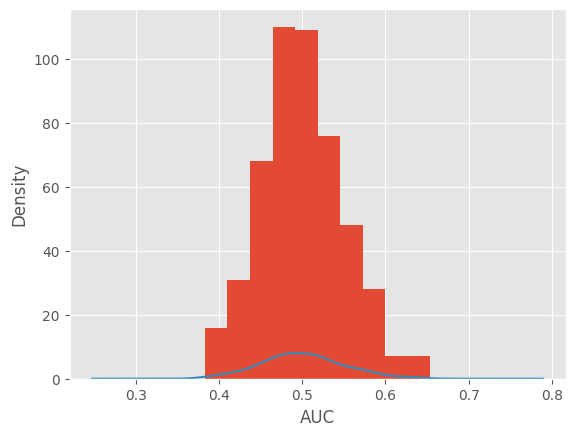

In [25]:
# Plot

AUCS = pd.DataFrame(AUCS, columns=['AUC'])

ax = AUCS.plot(kind='hist', legend=False)
AUCS.plot(kind='kde', ax=ax, legend=False)
ax.set_xlabel("AUC")
plt.show()

# 2 pts

In [26]:
# Find the confidence interval

# From assign4

bm = pd.DataFrame(data=AUCS-AUCS.AUC.mean())

boot_CL = 95/100 
p_1 = (1-boot_CL)/2
p_2 = 1-p_1
boot_quant = np.quantile(bm, [p_1, p_2])

ci_min = (AUCS.AUC.mean() - boot_quant[1]).round(3)
ci_max = (AUCS.AUC.mean() - boot_quant[0]).round(3)

print(f'The CI for the AUC of the model is: {(ci_min,ci_max) }')
# 6 pts

The CI for the AUC of the model is: (0.398, 0.594)
